In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from harmony import harmonize

import imap
import os
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

DataPath = "../Dataset/GSE94820_cleared/"
#PicPath --share with data

# load data

bat1 = sc.read_h5ad(DataPath+'batch1Data.h5ad')
bat2 = sc.read_h5ad(DataPath+'batch2Data.h5ad')

sc.pp.filter_cells(bat1, min_genes=300)
sc.pp.filter_genes(bat1, min_cells=10)

sc.pp.filter_cells(bat2, min_genes=300)
sc.pp.filter_genes(bat2, min_cells=10)

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.3 pandas==1.2.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.2
filtered out 6 cells that have less than 300 genes expressed
filtered out 12224 genes that are detected in less than 10 cells
filtered out 5 cells that have less than 300 genes expressed
filtered out 13298 genes that are detected in less than 10 cells


In [2]:
def output(Scadata,method):
    sc.pl.umap(Scadata, color=['batch','celltype'],s=10,save='UMAP_' + method + '.svg') #如何用矢量格式存？
    pd.DataFrame(Scadata.obsm['X_umap'],index = Scadata.obs.index,columns=['umap1','umap2']).to_csv(DataPath + method +'_lisi.csv')
    pd.DataFrame(Scadata.obsm['X_umap'].T, index=['umap1','umap2'], columns=Scadata.obs.index).to_csv(DataPath + method+'_kBET.csv')

    Scadata.obs.to_csv(DataPath + method+'_anno.csv')

# from iMAP 
def data2umap(data, n_pca=0):
    if n_pca > 0:
        pca = PCA(n_components=n_pca)
        embedding = pca.fit_transform(data)
    else:
        embedding = data
    embedding_ = umap.UMAP(
        n_neighbors=30,
        min_dist=0.3,
        metric='cosine',
        n_components = 2,
        learning_rate = 1.0,
        spread = 1.0,
        set_op_mix_ratio = 1.0,
        local_connectivity = 1,
        repulsion_strength = 1,
        negative_sample_rate = 5,
        angular_rp_forest = False,
        verbose = False
    ).fit_transform(embedding)
    return embedding_


normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


... storing 'celltype' as categorical


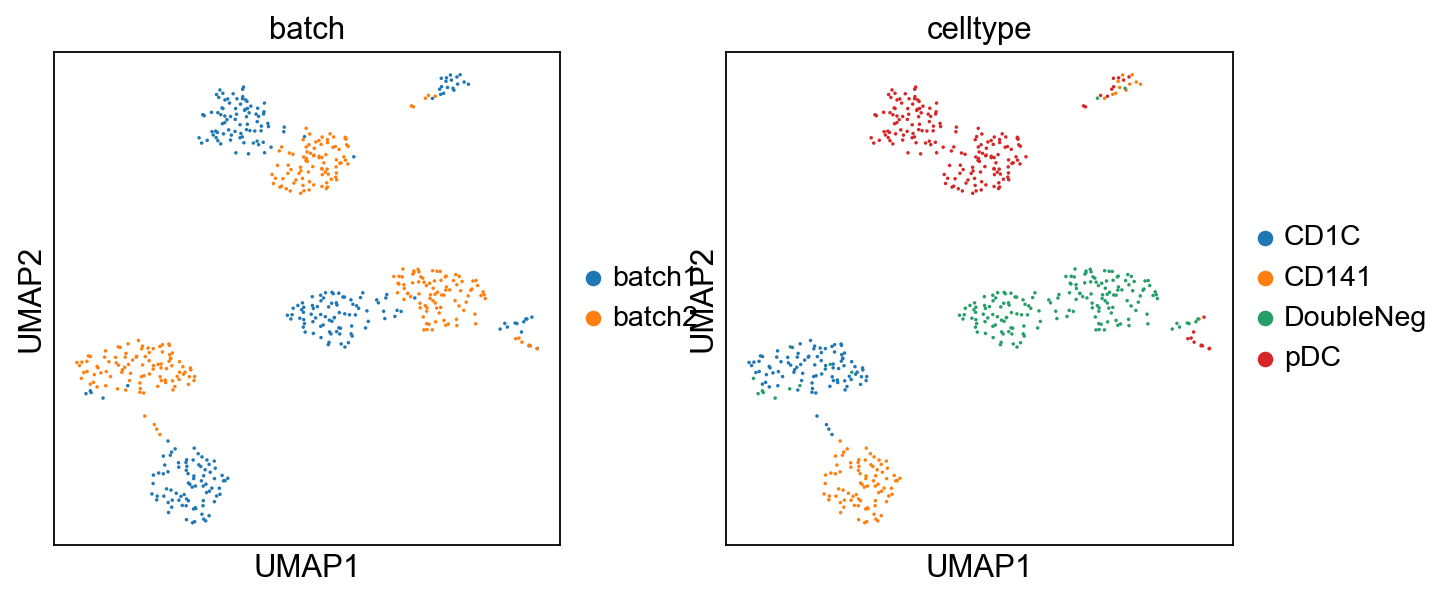

In [3]:
data_contact = bat1.concatenate(bat2, batch_categories=['batch1', 'batch2'])
sc.pp.normalize_total(data_contact)
sc.pp.log1p(data_contact)
#sc.pp.scale(data_contact)

sc.tl.pca(data_contact, svd_solver='arpack')
sc.pp.neighbors(data_contact, n_neighbors=10, n_pcs=30)
sc.tl.umap(data_contact)

#sc.pl.umap(data_contact,color = ['batch','celltype'],s=10)
output(data_contact,'Rawdata')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


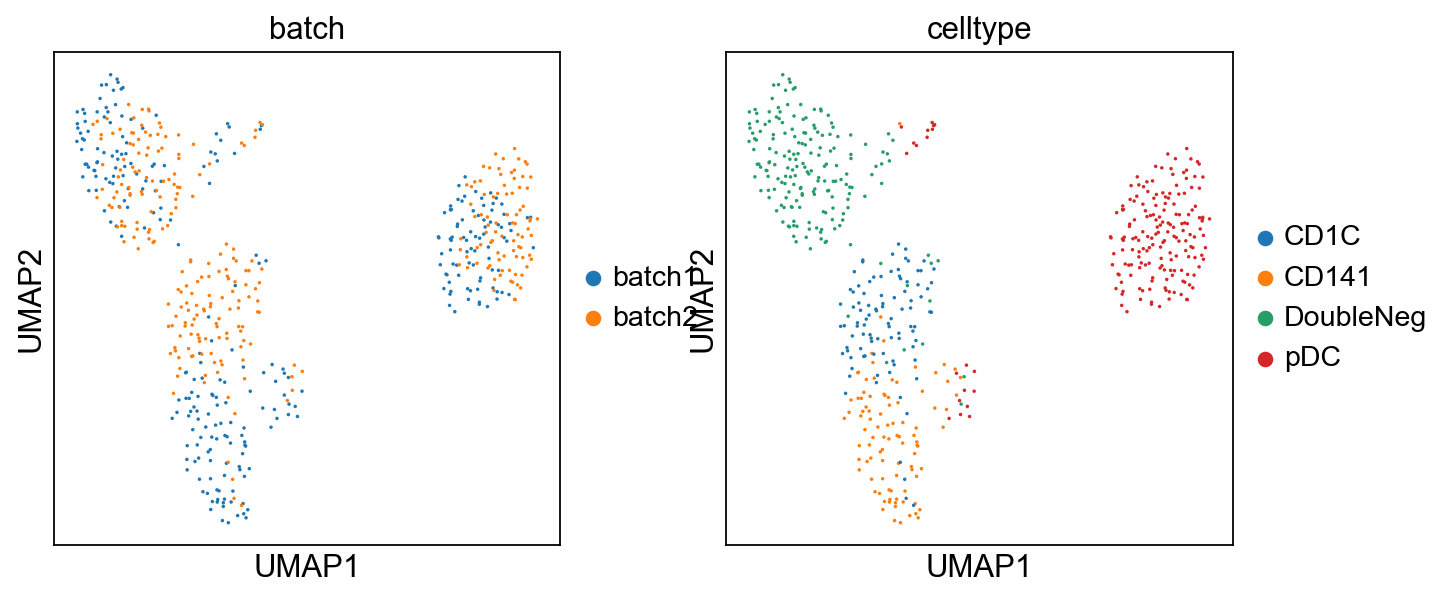

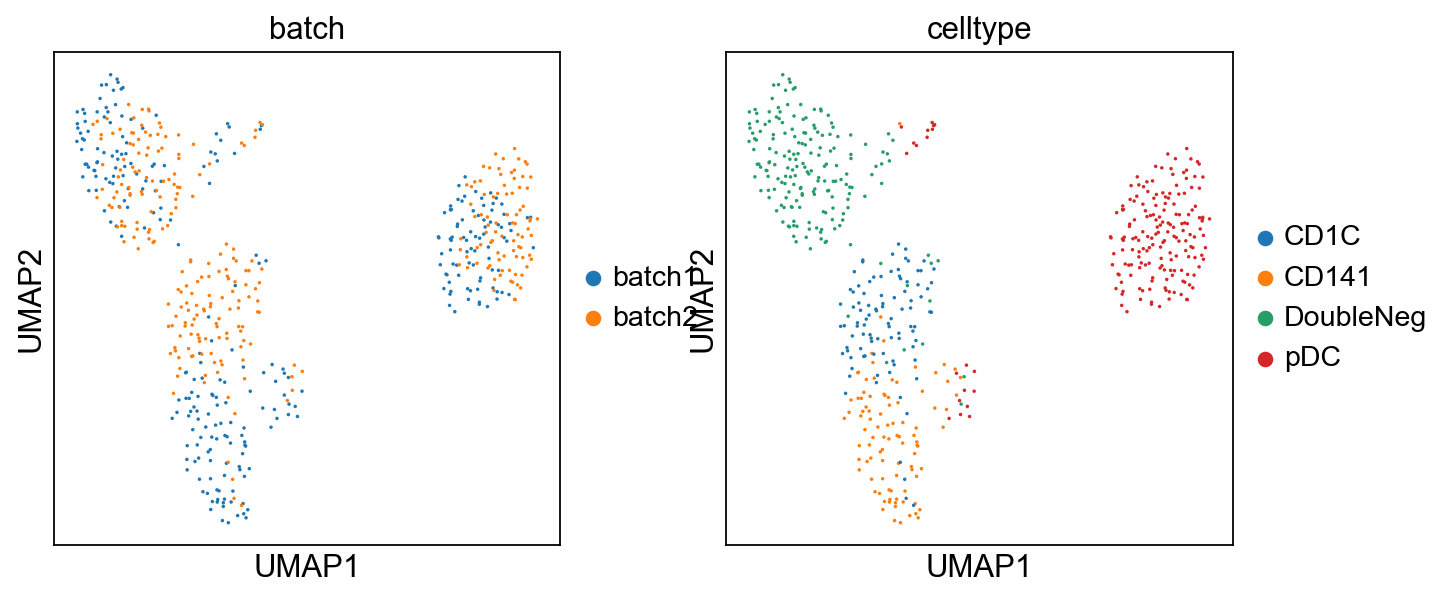

In [4]:
contactB= data_contact.copy()  
sc.external.pp.bbknn(contactB, batch_key='batch')
sc.tl.umap(contactB)

sc.pl.umap(contactB,color = ['batch','celltype'],s=10)
output(contactB,'BBKNN')

Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data

computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


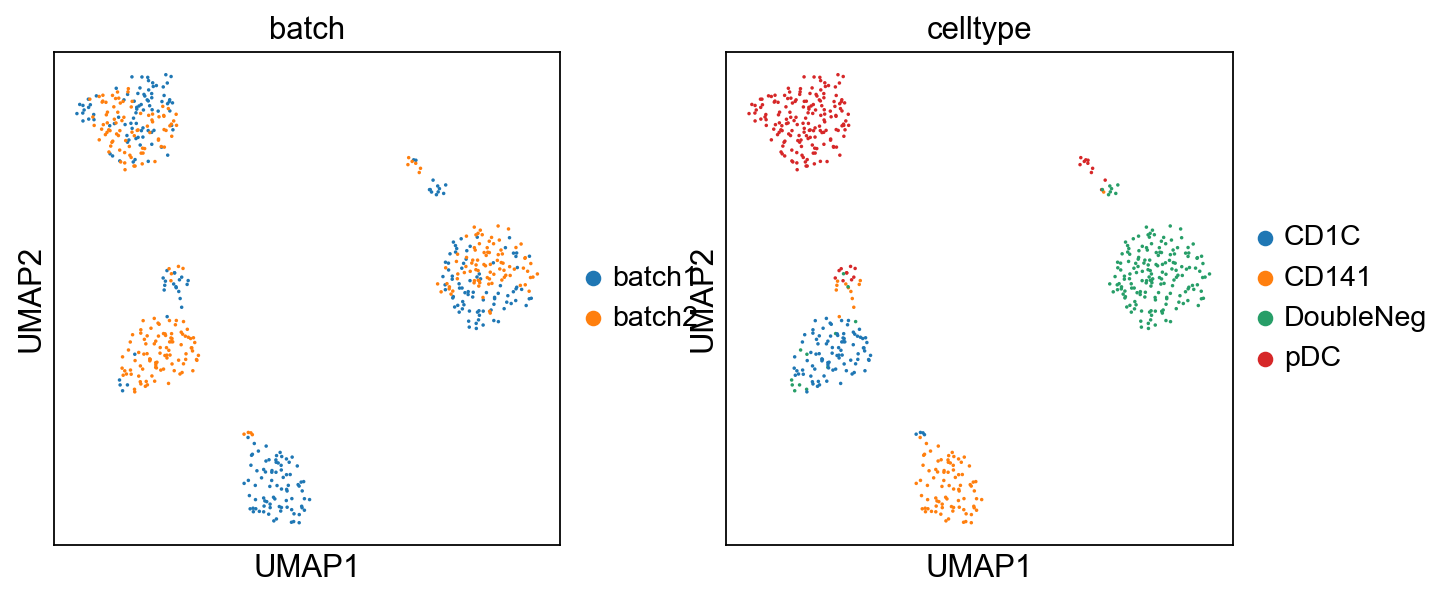

In [5]:
contactC = data_contact.copy()

sc.pp.combat(contactC, key='batch', covariates=None, inplace=True)
sc.tl.pca(contactC, svd_solver='arpack')

sc.pp.neighbors(contactC, n_neighbors=10, n_pcs=30) 
sc.tl.umap(contactC)

#sc.pl.umap(contactC,color = ['batch','celltype'],s=10)
output(contactC,'ComBat')

2021-08-07 18:25:02,093 - harmonypy - INFO - Iteration 1 of 10
2021-08-07 18:25:02,177 - harmonypy - INFO - Iteration 2 of 10
2021-08-07 18:25:02,244 - harmonypy - INFO - Iteration 3 of 10
2021-08-07 18:25:02,290 - harmonypy - INFO - Converged after 3 iterations


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


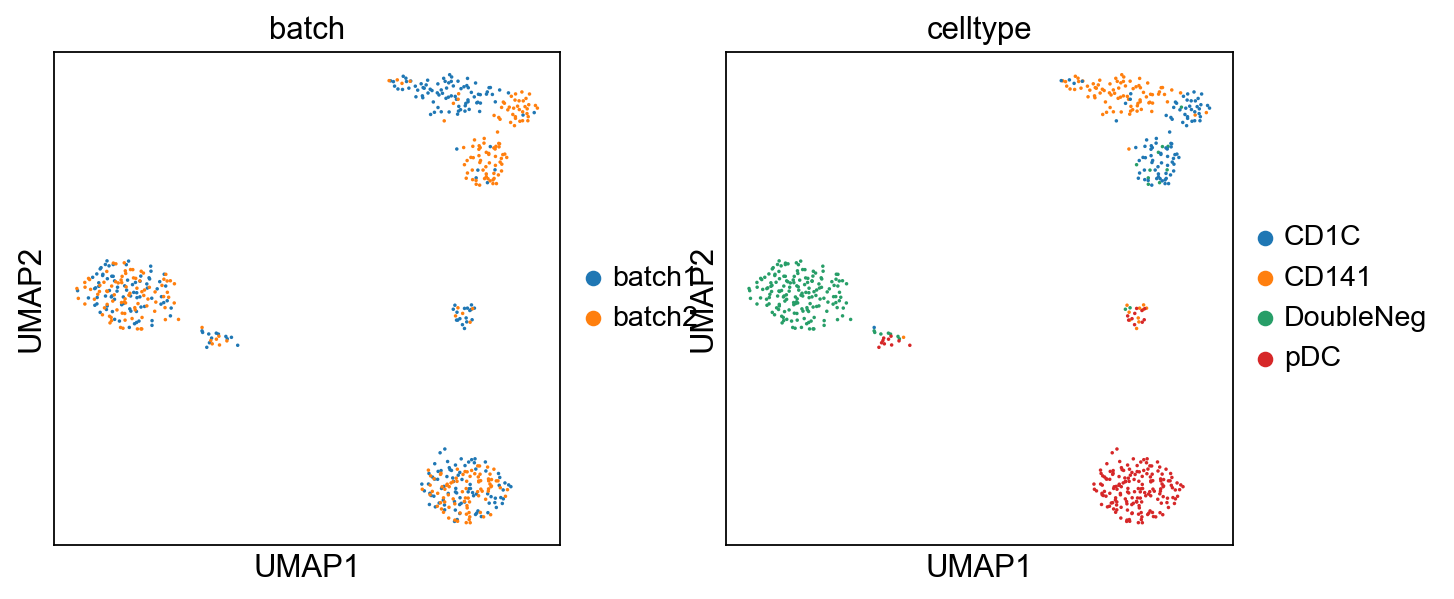

In [6]:
contactH = data_contact.copy()
import scanpy.external as sce

sce.pp.harmony_integrate(contactH, 'batch')
contactH.obsm['X_pca'] = contactH.obsm['X_pca_harmony']


sc.pp.neighbors(contactH, n_neighbors=10, n_pcs=30)  #30看起来正常一点?

sc.tl.umap(contactH)

#sc.pl.umap(contactH,color = ['batch','celltype'],s=10)
output(contactH,'Harmony')

Establishing Adata for Next Step...
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


D:\Anaconda\envs\SingleC\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
PreProcess Done.
Step 1: Calibrating Celltype...
[Epoch 1/50] [Reconstruction loss: 0.273673] [Cotent loss: 0.005733]
[Epoch 2/50] [Reconstruction loss: 0.271124] [Cotent loss: 0.001762]
[Epoch 3/50] [Reconstruction loss: 0.272574] [Cotent loss: 0.000860]
[Epoch 4/50] [Reconstruction loss: 0.267389] [Cotent loss: 0.000582]
[Epoch 5/50] [Reconstruction loss: 0.272504] [Cotent loss: 0.000462]
[Epoch 6/50] [Reconstruction loss: 0.271821] [Cotent loss: 0.000346]
[Epoch 7/50] [Reconstruction loss: 0.271338] [Cotent loss: 0.000428]
[Epoch 8/50] [Reconstruction loss: 0.270295] [Cotent loss: 0.000531]
[Epoch

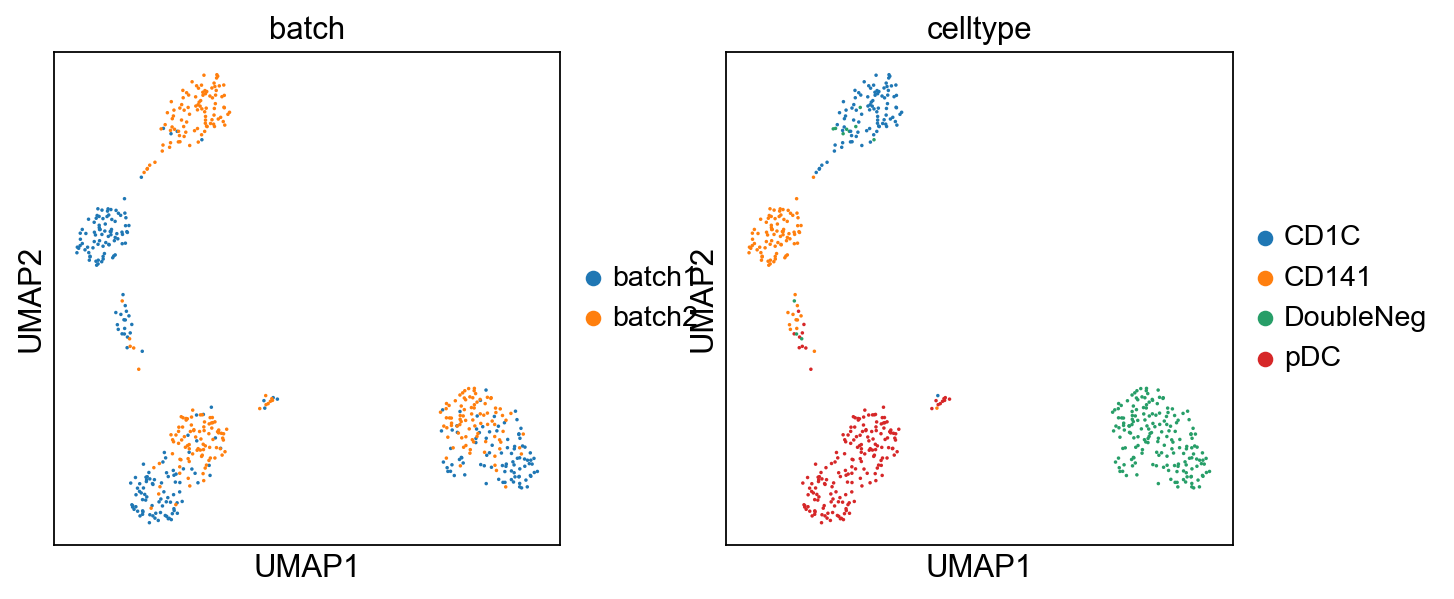

In [11]:
contactI = data_contact.copy()

contactI = imap.stage1.data_preprocess(contactI, 'batch')

EC, ec_data = imap.stage1.iMAP_fast(contactI, key="batch", n_epochs=50) 
output_results = imap.stage2.integrate_data(contactI, ec_data, inc = False, n_epochs=40)

embedding_ = data2umap(output_results, n_pca=30)
contactI.obsm['X_umap']= embedding_
output(contactI,'iMAP')
